In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import preprocessing as pp
import importlib
importlib.reload(pp)

import utils
importlib.reload(utils)

import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


# Generate Anchor boxes

In [2]:
## creat some sample toy anchor boxes for face detection
# input: feature map shape s = [0.1], r = [1, 1.25, 0.75] 
# note: these scale and ration is relative to input image both feature map and input image
# return (h, w, len(s)*len(r), 4) where x, y, w, h of range [0, 1]

def _gen_anchor_boxes(fmap_shape, s, r):
    """return (h, w, len(r), 4)
    where h, w is shape of fmap and each anchor box in form of centroids
    1 scaling factor s per layer
    """
    h, w = fmap_shape
    n_boxes = len(r)
    
    # first, i calculate the w,h for all set of scale and ratios
    # because w, h of anchor boxes are relative to feature map so
    anchor_w = s*np.sqrt(np.array(r))
    anchor_h = s/np.sqrt(np.array(r))
    
    #find the center points of each anchor box 
    # example: say h = 3, w = 2, n_box = 3
    center_x = np.tile(np.repeat(range(w), n_boxes), h)/w + 1/(2*w)
    center_y = np.repeat(range(h), n_boxes* h)/h + 1/(2*h)
    

    anchor_w = np.tile(np.reshape(anchor_w, -1), w*h)
    anchor_h = np.tile(np.reshape(anchor_h, -1), w*h)

    ### clip app anchor boxes is its go outside the image 
    xmin = np.maximum(0, center_x - anchor_w/2)
    ymin = np.maximum(0, center_y - anchor_h/2)
    
    xmax = np.minimum(1, center_x + anchor_w/2)
    ymax = np.minimum(1, center_y + anchor_h/2)
    
    # create all anchor boxes
    anchor_boxes = np.zeros((h*w*n_boxes, 4))

#no clipping
#     anchor_boxes[:, 0] = (xmin + xmax)/2
#     anchor_boxes[:, 1] = (ymin + ymax)/2
#     anchor_boxes[:, 2] = anchor_w
#     anchor_boxes[:, 3] = anchor_h

    anchor_boxes[:, 0] = center_x
    anchor_boxes[:, 1] = center_y
    anchor_boxes[:, 2] = anchor_w
    anchor_boxes[:, 3] = anchor_h
    
    #shape (m, 4)
    return anchor_boxes

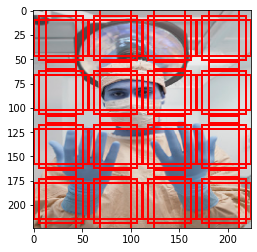

In [4]:
### test my code:
anchor_boxes = _gen_anchor_boxes((4, 4), s = [0.2], r = [1,1.5, 0.5])

#draw
img = cv2.resize(cv2.imread(pp.path), (224, 224))
pp.draw_box([pp.convert_coords(bb*224, kind= 'centroids_to_topleft') for bb in anchor_boxes], img)

In [6]:
def gen_anchor_tensor(x, s, r, variance):
    """input: tensor x , feature map of the predictor layer, shape of (b, h, w, c)
       ouput: tensor (b, nboxes, 4) 
       variance if an np.array of 4 elements
    """
    _, fh, fw, _ = x._keras_shape
    n_boxes = len(r)*fh*fw
    
    anchor_boxes = _gen_anchor_boxes((fh, fw), s, r)
#     anchor_boxes = K.tile(anchor_boxes, (K.shape(x)[0], 1, 1))
    
    variance = np.tile(variance, reps= (n_boxes, 1))
    out = np.expand_dims(np.concatenate((anchor_boxes, variance), axis = -1), axis= 0)
    
    return tf.tile(tf.constant(out, dtype = 'float32'), (K.shape(x)[0], 1, 1))

In [7]:
## test my code
from keras.layers  import Input

s = 0.2
r = [1, 1.15, 0.75]
variance = np.array([0.1, 0.1, 0.2, 0.2])
x = Input(shape=(23, 23, 2))
gen_anchor_tensor(x, s, r, variance)


<tf.Tensor 'Tile:0' shape=(None, 1587, 8) dtype=float32>

# for data generator

In [1]:
# do everything here in numpy
### labeling anchor boxes for an image
def all_anchor_boxes(fmap_shapes, ss, r ):
    """calculate anchor boxes in centroids for all predictor layers for 1 image 
    fmap_shape : list of fmap_shape
    ss : list of scale, 1 for each layer
    r: aspect ratios for all layers
    
    return (total_boxes, 4)"""
    
    total_anchor_boxes = [_gen_anchor_boxes(shape,s, r) for shape,s in zip(fmap_shapes, ss)]
    return np.concatenate(total_anchor_boxes, axis = 0)

class LabelAnchor():
    def __init__(self, anchor_boxes, variance, iou_threshold, neg_iou_threshold):
        self.ab = anchor_boxes
        self.variance = variance
        self.iou_threshold = iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
    
    def labeling_anchors(self,true_bbs):
        """true_label: 2D numpy arrays of true bbs, in relative values """
        # convert all all boxes from centroids to corners
    #     true_bbs = utils.convert_coords(true_bbs, kind= 'centroids_to_corners')
    #     anchor_boxes = utils.convert_coords(anchor_boxes, kind= 'centroids_to_corners')

        # calculate custom negative iou threshold
        self.neg_iou_threshold = np.minimum(len(true_bbs)*self.neg_iou_threshold, 0.4)

        # mask out all neutral boxes
        iou = utils.IOU(self.ab, true_bbs) # shape (total_boxes, m)

        score = np.max(iou, axis= 1) #(total boxes)

        # account for neutral boxes
        class_mask = 2*(score > self.iou_threshold) + (score < self.neg_iou_threshold) # (total_boxes)
        box_mask = (score > self.iou_threshold)

    #     print(class_mask, box_mask)

        indices = np.argmax(iou, axis= 1) #(total_boxes) # indices of true_bb for each anchor box
        indices *= box_mask # ie (np.array([0, 1, 3, 2, 0, 0, 0, 2]))

        ## matching to get label for anchor boxes
        # class label (neutral, neg, pos)
        label = np.array([
            [0, 0],
            [1, 0],
            [0, 1]
        ])
        anchor_classes = label[class_mask.astype('int')]

        # pad true box with an array of 0 for neutral boxes and negative boxes
        # only non zero array for postive boxes
        match_true_bbs = true_bbs[indices] #(total_boxes, 4)

        # calculate offset for anchor boxes (total_boxes, 4)
        offsets = np.zeros_like(self.ab)
        offsets[:, 0] = (match_true_bbs[:, 0] - self.ab[:, 0])/(self.variance[0]*self.ab[:, 2])
        offsets[:, 1] = (match_true_bbs[:, 1] - self.ab[:, 1])/(self.variance[1]*self.ab[:, 3])
        offsets[:, 2] = np.log(match_true_bbs[:, 2]/ self.ab[:, 2])/self.variance[2]
        offsets[:, 3] = np.log(match_true_bbs[:, 3]/ self.ab[:, 3])/self.variance[3]

        return np.concatenate((anchor_classes, offsets), axis = -1)


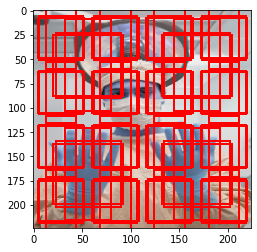

In [153]:
#test my code
true_bbs = np.array([
    [0, 0, 2, 2]
])
anchor_boxes = np.array([
    [0.5, 0.5, 2, 2],
    [0, 0, 1.5, 2.5],
    [2, 2, 4, 4],
    [0, 0,1, 1]
])
variance = np.array([0.1, 0.1, 0.2, 0.2]) 
iou_threshold = 0.3
neg_iou_threshold = 0.01

labeling_anchors(true_bbs, anchor_boxes, variance, iou_threshold, neg_iou_threshold)

ss = [0.2, 0.3]
fmap_shapes = [(4, 4), (2, 2)]
r = [1, 0.5, 1.15]
anchor_boxes = all_anchor_boxes(fmap_shapes, ss, r)
pp.draw_box([pp.convert_coords(bb*224, kind= 'centroids_to_topleft') for bb in anchor_boxes], img)